# Reinforcement Learning (PPO) with torchrl

In [1]:
!pip3 install torchrl
!pip3 install gym[mujoco]
!pip3 install tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.1/130.1 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 34.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 26.8 MB/s eta 0:00:00


In [7]:
pip install --upgrade ipykernel

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.0/154.0 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 58.2 MB/s eta 0:00:00
  Attempting uninstall: ipykernel
    Found existing installation: ipykernel 5.5.6
    Uninstalling ipykernel-5.5.6:
      Successfully uninstalled ipykernel-5.5.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires ipykernel==5.5.6, but you have ipykernel 6.25.1 which is incompatible.


근사적 정책 최적화(Proximal Policy Optimization, PPO)는 근사에 대한 제약조건이 있을 때, 수집된 데이터의 배치가 직접 훈련에 사용되어 기대되는 보상을 최대화하는 policy-gradient 알고리즘입니다.

PPO는 온라인, on-policy 강화학습 알고리즘이며 빠르고 효율적입니다. `TorchRL`은 모든 작업을 대신 수행해 줄 손실 모듈을 제공합니다.

알고리즘은 다음 단계를 따라 동작합니다.
1. 먼저 정해진 단계만큼 환경 내에서 정책을 실행하여 데이터의 배치를 샘플링합니다.
2. REINFORCE 손실의 clipped 버전을 사용하여 임의의 서브 샘플을 취하고 정해진 단계만큼 최적화를 수행합니다.
3. 클리핑은 손실에 대한 pessimistic bound를 정합니다. 더 낮은 보상이 선호됩니다. 공식은 다음과 같습니다.

$$
L(s,a,\theta_k, \theta) = \min \left( {{\pi_\theta (a|s)}\over{\pi_{\theta_k}}}A^{\pi_{\theta_k}}(s, a), g(\epsilon,A^{\pi_{\theta_k}}(s,a)) \right)
$$

이 손실에는 두 가지 요소가 있습니다. 먼저 최솟값 연산자 내의 첫 부분은, 단순히 importrance-weighted 버전의 REINFORCE 손실을 계산합니다. (예를들어 현재 정책의 configuration이 데이터 수집에 사용된 정책보다 뒤처진다는 것에 대해 수정된 REINFOCE 손실) 두 번째 부분은 임계값을 초과하거나 미만이면 클리핑한 비율과 유사한 손실입니다.

이 손실은 결국 이전에 비해서 큰 변화를 가져오도록 정책이 업데이트되지는 않습니다.


In [2]:
from collections import defaultdict

import matplotlib.pyplot as plt
import torch
from tensordict.nn import TensorDictModule
from tensordict.nn.distributions import NormalParamExtractor
from torch import nn
from torchrl.collectors import SyncDataCollector
from torchrl.data.replay_buffers import ReplayBuffer
from torchrl.data.replay_buffers.samplers import SamplerWithoutReplacement
from torchrl.data.replay_buffers.storages import LazyTensorStorage
from torchrl.envs import Compose, DoubleToFloat, ObservationNorm, StepCounter,TransformedEnv
from torchrl.envs.libs.gym import GymEnv
from torchrl.envs.utils import check_env_specs, set_exploration_mode
from torchrl.modules import ProbabilisticActor, TanhNormal, ValueOperator
from torchrl.objectives import ClipPPOLoss
from torchrl.objectives.value import GAE
from tqdm import tqdm

### 하이퍼파라미터 정의

In [8]:
device = "cpu" if not torch.has_cuda else "cuda:0"
num_cells = 256
lr = 3e-4
max_grad_norm = 1.0

In [9]:
frame_skip = 1
frames_per_batch = 1000 // frame_skip
total_frames = 50_000 // frame_skip

In [10]:
sub_batch_size = 64 # 카디널리티
num_epochs = 10
clip_epsilon = (
    0.2 # PPO 손실에 대한 clip value
)
gamma = 0.99
lmbda = 0.95
entropy_eps = 1e-4

### 환경 정의

In [11]:
base_env = GymEnv("InvertedDoublePendulum-v4", device=device, frame_skip=frame_skip)

In [12]:
env = TransformedEnv(
    base_env,
    Compose(
        # normalize observations
        ObservationNorm(in_keys=["observation"]),
        DoubleToFloat(in_keys=["observation"]),
        StepCounter(),
    ),
)

In [13]:
env.transform[0].init_stats(num_iter=1000, reduce_dim=0, cat_dim=0)

In [14]:
print("normalization constant shape:", env.transform[0].loc.shape)

normalization constant shape: torch.Size([11])


In [15]:
print("observation_spec:", env.observation_spec)
print("reward_spec:", env.reward_spec)
print("input_spec:", env.input_spec)
print("action_spec (as defined by input_spec):", env.action_spec)

observation_spec: CompositeSpec(
    observation: UnboundedContinuousTensorSpec(
         shape=torch.Size([11]), space=None, device=cuda:0, dtype=torch.float32, domain=continuous),
    step_count: UnboundedDiscreteTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True), maximum=Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, contiguous=True)), device=cuda:0, dtype=torch.int64, domain=continuous), device=cuda:0, shape=torch.Size([]))
reward_spec: UnboundedContinuousTensorSpec(
     shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True), maximum=Tensor(shape=torch.Size([]), device=cpu, dtype=torch.float32, contiguous=True)), device=cuda:0, dtype=torch.float32, domain=continuous)
input_spec: CompositeSpec(
    action: BoundedTensorSpec(
         shape=torch.Size([1]), space=ContinuousBox(minimum=Tensor(

In [16]:
check_env_specs(env)

check_env_specs succeeded!


In [17]:
rollout = env.rollout(3)
print("rollout of three steps:", rollout)
print("Shape of the rollout TensorDict:", rollout.batch_size)

rollout of three steps: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        next: TensorDict(
            fields={
                done: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.bool, is_shared=True),
                observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
                reward: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.float32, is_shared=True),
                step_count: Tensor(shape=torch.Size([3, 1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
            batch_size=torch.Size([3]),
            device=cuda:0,
            is_shared=True),
        observation: Tensor(shape=torch.Size([3, 11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([3, 1]), devi

### Policy

$$
f_\theta(\rm{observation}) = \mu_\theta(\rm{observation}), \sigma_\theta^+(\rm{observation})
$$

정책은 세 단계로 설계합니다.
1. 신경망의 `D_obs`를 `2 * D_action`으로 정의합니다. 실제로, `loc`(mu)와 `scale`(sigma)는 모두 `D_action` 차원을 갖습니다.
2. `NormalParamExtractor`를 추가하고 위치와 스케일을 추출합니다. (예를 들어 입력을 같은 두 부분으로 나누고, positive transformation을 적용하여 파라미터를 조정합니다.)
3. 확률적인 `TensorDictModule`를 정의하여 이 분포를 생성하고 여기서 샘플링을 수행할 수 있게 합니다.


In [18]:
actor_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(2 * env.action_spec.shape[-1], device=device),
    NormalParamExtractor(),
)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [19]:
policy_module = TensorDictModule(
    actor_net, in_keys=["observation"], out_keys=["loc", "scale"]
)

In [20]:
policy_module = ProbabilisticActor(
    module=policy_module,
    spec=env.action_spec,
    in_keys=["loc", "scale"],
    distribution_class=TanhNormal,
    distribution_kwargs={
        "min": env.action_spec.space.minimum,
        "max": env.action_spec.space.maximum,
    },
    return_log_prob=True,
)

### Value Network

Value network는 인퍼런스에서는 사용되지 않음에도 PPO 알고리즘에서 매우 중요합니다. 이 모듈은 관찰을 읽고 다음 궤적(trajectory)에 대해서 할인된 결과를 추정합니다. 훈련 중에 즉석으로 학습한 일부 utility 추정에 의존하여 학습을 상각할 수 있습니다.

In [21]:
value_net = nn.Sequential(
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(num_cells, device=device),
    nn.Tanh(),
    nn.LazyLinear(1, device=device),
)

value_module = ValueOperator(
    module=value_net,
    in_keys=["observation"],
)

In [22]:
print("Running policy:", policy_module(env.reset()))
print("Running value:", value_module(env.reset()))

Running policy: TensorDict(
    fields={
        action: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        loc: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), device=cuda:0, dtype=torch.float32, is_shared=True),
        sample_log_prob: Tensor(shape=torch.Size([]), device=cuda:0, dtype=torch.float32, is_shared=True),
        scale: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.float32, is_shared=True),
        step_count: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.int64, is_shared=True)},
    batch_size=torch.Size([]),
    device=cuda:0,
    is_shared=True)
Running value: TensorDict(
    fields={
        done: Tensor(shape=torch.Size([1]), device=cuda:0, dtype=torch.bool, is_shared=True),
        observation: Tensor(shape=torch.Size([11]), de

### 데이터 수집기

`TorchRL`은 `DataCollector` 클래스를 제공합니다. 이 클래스는 환경을 초기화하고, 최근 관찰에 대한 행동을 계산하는 과정을 환경이 중단될 때까지 반복합니다.

`frames_per_batch`는 각 반복(iteration)마다 얼마나 많은 프레임을 수집할 지를 결정하고, 언제 환경을 초기화 할지를 `max_frames_per_tarj` 인자로 조정합니다.

In [23]:
collector = SyncDataCollector(
    env,
    policy_module,
    frames_per_batch=frames_per_batch,
    total_frames=total_frames,
    split_trajs=False,
    device=device,
)

### 재현 버퍼

Replay buffer는 off-policy RL 알고리즘의 일부입니다. On-policy에서 재현 버퍼는 데이터의 한 배치가 수집될 때마다 다시 채워집니다. 그리고 데이터는 특정 에포크마다 반복적으로 사용됩니다.


In [24]:
replay_buffer = ReplayBuffer(
    storage=LazyTensorStorage(frames_per_batch),
    sampler=SamplerWithoutReplacement(),
)


### 손실함수

PPO 손실은 `ClipPPOLoss` 클래스를 불러와서 사용합니다.

In [25]:
advantage_module = GAE(
    gamma=gamma, lmbda=lmbda, value_network=value_module, average_gae=True
)

loss_module = ClipPPOLoss(
    actor=policy_module,
    critic=value_module,
    advantage_key="advantage",
    clip_epsilon=clip_epsilon,
    entropy_bonus=bool(entropy_eps),
    entropy_coef=entropy_eps,
    # these keys match by default but we set this for completeness
    value_target_key=advantage_module.value_target_key,
    critic_coef=1.0,
    gamma=0.99,
    loss_critic_type="smooth_l1",
)

optim = torch.optim.Adam(loss_module.parameters(), lr)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optim, total_frames // frames_per_batch, 0.0
)

/usr/local/lib/python3.10/dist-packages/torchrl/objectives/ppo.py:163: DeprecationWarning: Passing gamma / lambda parameters through the loss constructor is deprecated and will be removed soon. To customize your value function, run `loss_module.make_value_estimator(ValueEstimators.<value_fun>, gamma=val)`.
  warnings.warn(_GAMMA_LMBDA_DEPREC_WARNING, category=DeprecationWarning)


### 학습 루프

In [26]:
logs = defaultdict(list)
pbar = tqdm(total=total_frames * frame_skip)
eval_str = ""

for i, tensordict_data in enumerate(collector):
    for _ in range(num_epochs):

        advantage_module(tensordict_data)
        data_view = tensordict_data.reshape(-1)
        replay_buffer.extend(data_view.cpu())
        for _ in range(frames_per_batch // sub_batch_size):
            subdata = replay_buffer.sample(sub_batch_size)
            loss_vals = loss_module(subdata.to(device))
            loss_value = (
                loss_vals["loss_objective"]
                + loss_vals["loss_critic"]
                + loss_vals["loss_entropy"]
            )

            loss_value.backward()

            torch.nn.utils.clip_grad_norm_(loss_module.parameters(), max_grad_norm)
            optim.step()
            optim.zero_grad()

    logs["reward"].append(tensordict_data["next", "reward"].mean().item())
    pbar.update(tensordict_data.numel() * frame_skip)
    cum_reward_str = (
        f"average reward={logs['reward'][-1]: 4.4f} (init={logs['reward'][0]: 4.4f})"
    )
    logs["step_count"].append(tensordict_data["step_count"].max().item())
    stepcount_str = f"step count (max): {logs['step_count'][-1]}"
    logs["lr"].append(optim.param_groups[0]["lr"])
    lr_str = f"lr policy: {logs['lr'][-1]: 4.4f}"
    if i % 10 == 0:
        with set_exploration_mode("mean"), torch.no_grad():
            eval_rollout = env.rollout(1000, policy_module)
            logs["eval reward"].append(eval_rollout["next", "reward"].mean().item())
            logs["eval reward (sum)"].append(
                eval_rollout["next", "reward"].sum().item()
            )
            logs["eval step_count"].append(eval_rollout["step_count"].max().item())
            eval_str = (
                f"eval cumulative reward: {logs['eval reward (sum)'][-1]: 4.4f} "
                f"(init: {logs['eval reward (sum)'][0]: 4.4f}), "
                f"eval step-count: {logs['eval step_count'][-1]}"
            )
            del eval_rollout
    pbar.set_description(", ".join([eval_str, cum_reward_str, stepcount_str, lr_str]))


    scheduler.step()

  2%|▏         | 1000/50000 [00:07<05:46, 141.27it/s]/usr/local/lib/python3.10/dist-packages/tensordict/nn/probabilistic.py:79: DeprecationWarning: set_interaction_mode is deprecated for naming clarity. Please use set_interaction_type with InteractionType enum instead.
  _insert_interaction_mode_deprecation_warning("set_")
eval cumulative reward:  1916.3146 (init:  92.3670), eval step-count: 204, average reward= 9.3312 (init= 9.0858), step count (max): 204, lr policy:  0.0000: 100%|██████████| 50000/50000 [04:47<00:00, 185.41it/s]

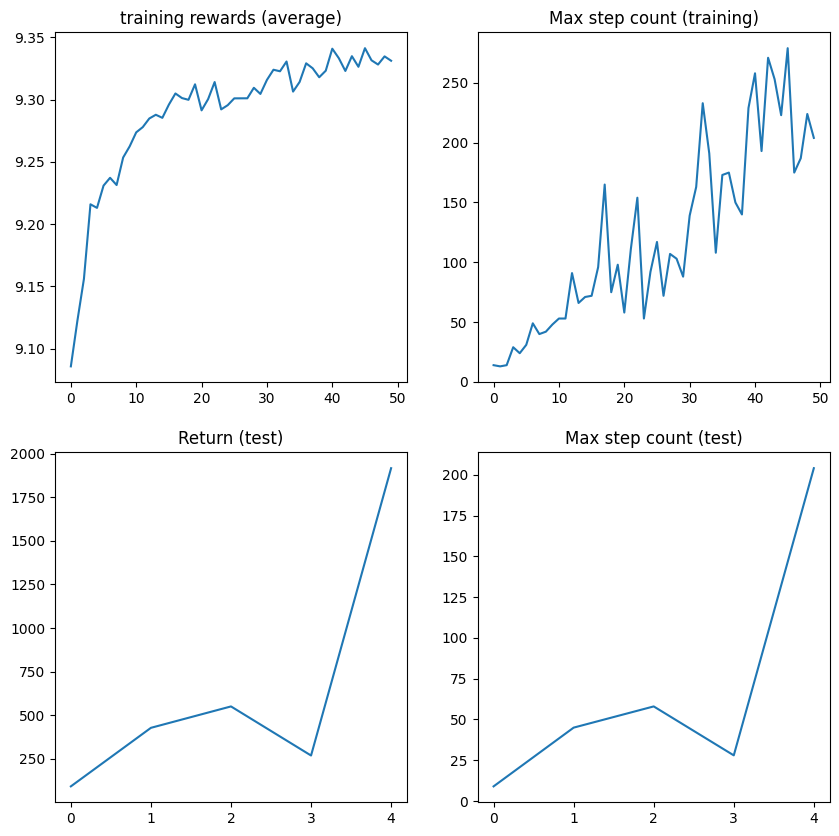

In [27]:
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.plot(logs["reward"])
plt.title("training rewards (average)")
plt.subplot(2, 2, 2)
plt.plot(logs["step_count"])
plt.title("Max step count (training)")
plt.subplot(2, 2, 3)
plt.plot(logs["eval reward (sum)"])
plt.title("Return (test)")
plt.subplot(2, 2, 4)
plt.plot(logs["eval step_count"])
plt.title("Max step count (test)")
plt.show()